# Interactively run workflow calcium imaging

+ This notebook walks you through the steps in detail to run the `workflow-calcium-imaging`.  

+ The workflow requires the calcium imaging acquired data from ScanImage or Scanbox and processed data from Suite2p or CaImAn.

+ If you haven't configured the paths, refer to [01-configure](01-configure.ipynb).

+ To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb).

+ If you need a more automatic approach to run the workflow, refer to [03-automate](03-automate-optional.ipynb).

Let's change the directory to the package root directory to load the local configuration (`dj_local_conf.json`).

In [1]:
# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
if os.path.basename(os.getcwd()) == "notebooks": os.chdir("..")
import numpy as np

## `Pipeline.py`

+ This script `activates` the DataJoint `elements` and declares other required tables.

In [3]:
import datajoint as dj
from workflow_calcium_imaging.pipeline import *

[2023-02-22 16:27:54,248][INFO]: Connecting jure@127.0.0.1:3306
[2023-02-22 16:27:54,339][INFO]: Connected jure@127.0.0.1:3306


In [4]:
# clear any previous entries
subject.Subject.delete()
Equipment.delete()

[2023-02-22 16:27:54,753][INFO]: Deleting 3243 rows from `jure_imaging`.`__activity__trace`
[2023-02-22 16:27:54,762][INFO]: Deleting 2 rows from `jure_imaging`.`__activity`
[2023-02-22 16:27:54,929][INFO]: Deleting 3243 rows from `jure_imaging`.`__fluorescence__trace`
[2023-02-22 16:27:54,936][INFO]: Deleting 2 rows from `jure_imaging`.`__fluorescence`
[2023-02-22 16:27:54,973][INFO]: Deleting 2425 rows from `jure_imaging`.`__mask_classification__mask_type`
[2023-02-22 16:27:54,980][INFO]: Deleting 2 rows from `jure_imaging`.`__mask_classification`
[2023-02-22 16:27:55,039][INFO]: Deleting 3243 rows from `jure_imaging`.`__segmentation__mask`
[2023-02-22 16:27:55,052][INFO]: Deleting 2 rows from `jure_imaging`.`__segmentation`
[2023-02-22 16:27:55,079][INFO]: Deleting 72 rows from `jure_imaging`.`_motion_correction__block`
[2023-02-22 16:27:55,086][INFO]: Deleting 2 rows from `jure_imaging`.`_motion_correction__non_rigid_motion_correction`
[2023-02-22 16:27:55,101][INFO]: Deleting 2 ro

Deletes committed.
Deletes committed.


1

## Insert an entry into `subject.Subject`

In [5]:
subject.Subject.heading

subject              : varchar(8)                   # 
---
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [6]:
from element_interface.prairieviewreader import get_pv_metadata

In [7]:
import pandas as pd

In [8]:
fake_session_datetime_str_init = '2002-01-01 12:00:00.000' # making up session datetime (to query data use either the session/folder name or PraireView metadata)

In [9]:
fake_session_datetime_str = fake_session_datetime_str_init[:22] + str(1)
fake_session_datetime_str

'2002-01-01 12:00:00.001'

In [10]:
# custom function to populate database
root_data_dir = dj.config['custom']['imaging_root_data_dir']

all_subject_str = []
all_session_str = [] # this will be list of lists - each nested list corresponding to one subject
all_datetime_str = [] # for now hardcoded! (figure out how to do programmatically)

count = 0
for subject_str in os.listdir(root_data_dir):
    print(f'Subject: {subject_str}')
    all_subject_str.append(subject_str)
    
    all_subject_session_str = [] # sessions for this particular subject
    all_subject_datetime_str = []
    for subject_session_str in os.listdir(root_data_dir + '/' + subject_str):
        all_subject_session_str.append(subject_session_str)
        fake_session_datetime_str = fake_session_datetime_str_init[:18] + str(count) + '.000' # making fake unique time
        print(fake_session_datetime_str)
        all_subject_datetime_str.append(fake_session_datetime_str) # here it is fake
        count += 1
        
    print(f'Identified sessions for subject {subject_str}: {all_subject_session_str}')

    all_session_str.append(all_subject_session_str) 
    all_datetime_str.append(all_subject_datetime_str) 

Subject: jm003
2002-01-01 12:00:00.000
2002-01-01 12:00:01.000
Identified sessions for subject jm003: ['2022-05-05_b', '2022-05-05_c']


In [11]:
print(f'All subjects: {all_subject_str}')
print(f'All session: {all_session_str}')


All subjects: ['jm003']
All session: [['2022-05-05_b', '2022-05-05_c']]


In [12]:
for subject_str in all_subject_str:
    
    subject.Subject.insert1(dict(subject=subject_str, 
                                 sex='U', 
                                 subject_birth_date='2020-01-01', # figure out how to handle
                                 subject_description=''))

In [13]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
jm003,U,2020-01-01,


## Insert an entry into `lab.Equipment`

In [14]:
Equipment.insert1(dict(scanner='PrairieView'))

## Insert an entry into `session.Session`

In [15]:
session.Session.describe();

-> Subject
session_datetime     : datetime                     



In [16]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

In [17]:
session.Session()

subject,session_datetime


In [18]:
all_datetime_str

[['2002-01-01 12:00:00.000', '2002-01-01 12:00:01.000']]

In [19]:
for (i, subject_str) in enumerate(all_subject_str):
    for (j, subject_session_str) in enumerate(all_session_str[i]):
        
        session_datetime_str = all_datetime_str[i][j]
        print(session_datetime_str)
        session_key = dict(subject=subject_str, session_datetime=session_datetime_str)

        session.Session.insert1(session_key)

session.Session()

2002-01-01 12:00:00.000
2002-01-01 12:00:01.000


subject,session_datetime
jm003,2002-01-01 12:00:00
jm003,2002-01-01 12:00:01


## Insert an entry into `session.SessionDirectory`

+ The `session_dir` is the relative path to the `imaging_root_data_dir` for the given session, in POSIX format with `/`.

+ Instead of a relative path, `session_dir` could be an absolute path but it is not recommended as the absolute path would have to match the `imaging_root_data_dir` in `dj_local_conf.json`.

In [20]:
session.SessionDirectory.describe();

-> Session
---
session_dir          : varchar(256)                 # Path to the data directory for a session



In [21]:
session.SessionDirectory.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
---
session_dir          : varchar(256)                 # Path to the data directory for a session

In [22]:
for (i, subject_str) in enumerate(all_subject_str):
    for (j, subject_session_str) in enumerate(all_session_str[i]):
        session_datetime_str = all_datetime_str[i][j]
        
        session.SessionDirectory.insert1(dict(subject=subject_str, 
                                              session_datetime=session_datetime_str, 
                                              session_dir=f'{subject_str}/{subject_session_str}'))

        session.SessionDirectory()

## Insert an entry into `scan.Scan`

In [23]:
scan.Scan.heading

subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
---
scanner=null         : varchar(32)                  # 
acq_software         : varchar(24)                  # 
scan_notes=""        : varchar(4095)                # 

In [24]:
for (i, subject_str) in enumerate(all_subject_str):
    for (j, subject_session_str) in enumerate(all_session_str[i]):
        session_datetime_str = all_datetime_str[i][j]
        
        scan.Scan.insert1(dict(subject=subject_str, 
                               session_datetime=session_datetime_str, 
                               scan_id=0, 
                               scanner='PrairieView', 
                               acq_software='PrairieView',
                               scan_notes=''))
        scan.Scan()

## Populate `scan.ScanInfo`

+ This imported table stores information about the acquired image (e.g. image dimensions, file paths, etc.).
+ `populate` automatically calls `make` for every key for which the auto-populated table is missing data.
+ `populate_settings` passes arguments to the `populate` method.
+ `display_progress=True` reports the progress bar

In [25]:
scan.ScanInfo.describe();

# General data about the reso/meso scans from header
-> scan.Scan
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float                        # (Hz) frames per second - Volumetric Scan Rate
bidirectional        : tinyint                      # true = bidirectional scannin

/home/cossart/anaconda3/envs/dj_cossart/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/cossart/anaconda3/envs/dj_cossart/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/cossart/anaconda3/envs/dj_cossart/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


In [26]:
scan.ScanInfo.heading

# General data about the reso/meso scans from header
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float  

In [27]:
populate_settings = {'display_progress': True}

In [28]:
scan.ScanInfo.populate(**populate_settings)
scan.ScanInfo()

ScanInfo:   0%|          | 0/2 [00:00<?, ?it/s]




Scan_filepaths:
/media/cossart/DATA/dj_cossart_testing_delete/jm003/2022-05-05_b/TSeries-05052022-002_Cycle00001_Ch2_000001.ome.tif






IMPORTANT: JM: I also changed default number of roi from 1 to 0, because 1 throws an error with auto-populating suite2p



{'num_fields': 1, 'num_channels': 1, 'num_planes': 1, 'num_frames': 18000, 'num_rois': 0, 'x_pos': None, 'y_pos': None, 'z_pos': None, 'frame_rate': 30.23921639304208, 'bidirectional': False, 'bidirectional_z': False, 'scan_datetime': datetime.datetime(2022, 5, 5, 11, 14, 1), 'usecs_per_line': 63.11, 'scan_duration': 604.81085753, 'height_in_pixels': 512, 'width_in_pixels': 512, 'height_in_um': 752.5374145480857, 'width_in_um': 752.5374145480857, 'fieldX': 0.0, 'fieldY': 0.0, 'fieldZ': 136.225, 'recording_time': '11:14:02.8708799'}


ScanInfo:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it]




Scan_filepaths:
/media/cossart/DATA/dj_cossart_testing_delete/jm003/2022-05-05_c/TSeries-05052022-003_Cycle00001_Ch2_000001.ome.tif






IMPORTANT: JM: I also changed default number of roi from 1 to 0, because 1 throws an error with auto-populating suite2p






IMPORTANT: here I (JM) hardcoded the subindex because of the issue of two z devices (see: https://github.com/datajoint/element-interface/issues/77)



{'num_fields': 1, 'num_channels': 1, 'num_planes': 3, 'num_frames': 25200, 'num_rois': 0, 'x_pos': None, 'y_pos': None, 'z_pos': None, 'frame_rate': 30.234307721579153, 'bidirectional': False, 'bidirectional_z': True, 'scan_datetime': datetime.datetime(2022, 5, 5, 11, 37, 55), 'usecs_per_line': 63.120000000000005, 'scan_duration': 1224.733540734, 'height_in_pixels': 512, 'width_in_pixels': 512, 'height_in_um': 752.5374145480857, 'width_in_um': 752.5374145480857, 'fieldX': 0.0, 'fieldY': 0.0, 'fieldZ': array([3.26849658e-11, 2.50000000e+01, 5.00000000e+01]), 'recording_time': 

ScanInfo: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan
jm003,2002-01-01 12:00:00,0,1,1,1,18000,0,nan,nan,nan,30.2392,0,63.11,nan,2022-05-05 11:14:01,604.811,0
jm003,2002-01-01 12:00:01,0,1,1,3,25200,0,nan,nan,nan,30.2343,0,63.12,nan,2022-05-05 11:37:55,1224.73,1


## Insert new ProcessingTask to trigger ingestion of motion correction and segmentation results

+ Motion correction and segmentation are performed for each scan in Suite2p or CaImAn.

+ An entry in `ProcessingTask` indicates a set of motion correction and segmentation results (generated from Suite2p or CaImAn outside of `workflow-calcium-imaging`) are ready to be ingested.  In a future release, an entry in `ProcessingTask` can also indicate a new processing job (using Suite2p or CaImAn) is to be triggered.

+ Two pieces of information need to be specified:

    + The `paramset_idx` is the parameter set stored in `imaging.ProcessingParamSet` that is used for the Suite2p or CaImAn processing job.
    
    + The `processing_output_dir` stores the directory of the processing results (relative to the imaging root data directory).

In [29]:
for (i, subject_str) in enumerate(all_subject_str):
    for (j, subject_session_str) in enumerate(all_session_str[i]):
        session_datetime_str = all_datetime_str[i][j]


        imaging.ProcessingTask.insert1(dict(subject=subject_str, 
                                            session_datetime=session_datetime_str, 
                                            scan_id=0,
                                            paramset_idx=0,
                                            processing_output_dir=f'{subject_str}/{subject_session_str}/suite2p'))

## Populate `imaging.Processing`

In [30]:
imaging.Processing.populate(**populate_settings)

Processing: 100%|██████████| 2/2 [00:00<00:00, 51.52it/s]


## Insert new Curation following the ProcessingTask

+ The next step in the pipeline is the curation of motion corection and segmentation results.

+ If a manual curation was implemented, an entry needs to be manually inserted into the table `imaging.Curation`, which specifies the directory to the curated results in `curation_output_dir`. 

+ If we would like to use the processed outcome directly, an entry is also needed in `imaging.Curation`. A method `create1_from_processing_task` was provided to help this insertion. It copies the `processing_output_dir` in `imaging.ProcessingTask` to the field `curation_output_dir` in the table `imaging.Curation` with a new `curation_id`.

    + In this example, we create/insert one `imaging.Curation` for each `imaging.ProcessingTask`, specifying the same output directory.

    + To this end, we could also make use of a convenient function `imaging.Curation().create1_from_processing_task()`

In [31]:
imaging.Curation.heading

subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
paramset_idx         : smallint                     # Uniqiue parameter set ID.
curation_id          : int                          # 
---
curation_time        : datetime                     # Time of generation of this set of curated results
curation_output_dir  : varchar(255)                 # Output directory of the curated results, relative to root data directory
manual_curation      : tinyint                      # Has manual curation been performed on this result?
curation_note=""     : varchar(2000)                # 

In [32]:
for (i, subject_str) in enumerate(all_subject_str):
    for (j, subject_session_str) in enumerate(all_session_str[i]):
        session_datetime_str = all_datetime_str[i][j]
        
        imaging.Curation.insert1(dict(subject=subject_str, 
                                        session_datetime=session_datetime_str, 
                                        scan_id=0,
                                        paramset_idx=0,
                                        curation_id=0,
                                        curation_time=session_datetime_str, 
                                        curation_output_dir=f'{subject_str}/{subject_session_str}/suite2p',
                                        manual_curation=False,
                                        curation_note=''))

In [33]:
imaging.MotionCorrection.populate(**populate_settings)
imaging.Segmentation.populate(**populate_settings)
imaging.MaskClassification.populate(**populate_settings)
imaging.Fluorescence.populate(**populate_settings)
imaging.Activity.populate(**populate_settings)

Activity: 100%|██████████| 2/2 [00:12<00:00,  6.43s/it]


# Testing if data is loaded correctly

In [71]:
session_key = (imaging.Fluorescence & 'subject = "jm003"').fetch('KEY')[0]
print(session_key)

{'subject': 'jm003', 'session_datetime': datetime.datetime(2002, 1, 1, 12, 0), 'scan_id': 0, 'paramset_idx': 0, 'curation_id': 0}


In [72]:
imaging.MotionCorrection & session_key

subject,session_datetime,scan_id,paramset_idx Uniqiue parameter set ID.,curation_id,motion_correct_channel 0-based indexing
jm003,2002-01-01 12:00:00,0,0,0,0


In [73]:
import matplotlib.pyplot as plt

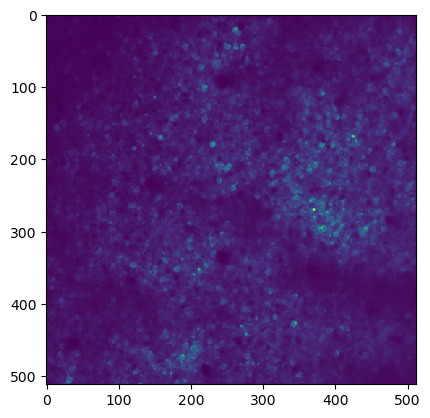

In [74]:
avg_im = (imaging.MotionCorrection.Summary & session_key).fetch1('average_image')
plt.imshow(np.array(avg_im))

In [103]:
from scipy.stats import zscore

In [121]:
imaging.Activity.Trace & session_key

subject,session_datetime,scan_id,paramset_idx Uniqiue parameter set ID.,curation_id,extraction_method,mask,fluo_channel 0-based indexing,activity_trace
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,0,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,1,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,2,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,3,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,4,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,5,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,6,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,7,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,8,0,=BLOB=
jm003,2002-01-01 12:00:00,0,0,0,suite2p_deconvolution,9,0,=BLOB=


In [126]:
F = (imaging.Fluorescence.Trace & session_key).fetch('fluorescence')

In [127]:
F_toplot = zscore(np.stack(F), 1)

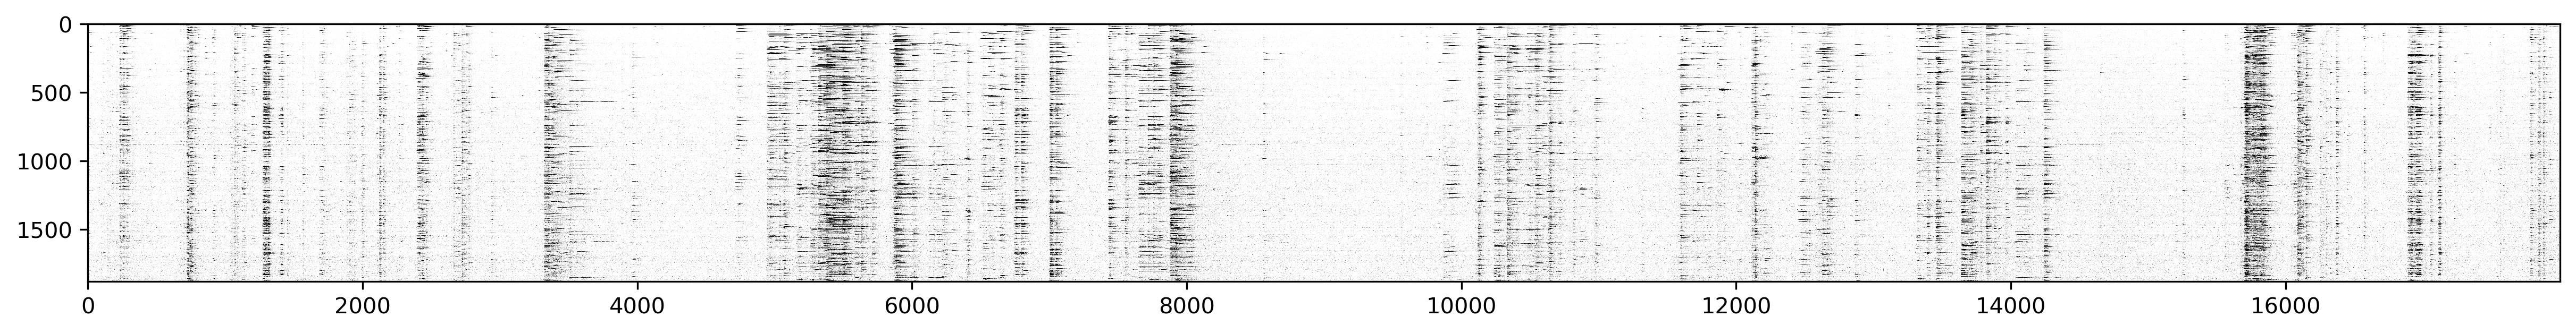

In [129]:
plt.figure(figsize=(20,20), dpi=300)
plt.imshow(F_toplot,cmap='Greys', vmin=0, vmax=3.65)